In [32]:
import sys
import os

sys.path.append('/home/lojze/development/lars_evaluator/')
from panopticapi.utils import id2rgb, rgb2id
import cv2

In [3]:
import pandas as pd
import os
import os.path as osp
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

from evaluator.config import get_cfg

/home/lojze/development/lars_evaluator/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
VIS_COLORS = {
    0: [0, 0, 0],
    1: [247, 195, 37],
    3: [41, 167, 224],
    5: [90, 75, 164],
}
# DYN_OBST_COLOR = [36, 123, 160]
DYN_OBST_COLOR = [197, 34, 51]
# DYN_OBST_COLOR = [236, 121, 5]
    
DYN_OBST_FACTOR = 0.4

In [96]:
data_path = "/home/lojze/data/datasets/LaRS/split/test"
results_path = "/home/lojze/development/lars_evaluator/results"
segmentation_path = "/home/lojze/data/predictions/lars/panoptic"
config_file = '../configs/lars_test_panoptic.yaml'

method_names = [
    'panoptic_fpn_r50_fpn_10x_LaRS',
    'max_deeplab_s_1025_50k',
    'mask2former_swin-b-p4-w12-384-in21k_lsj_8x2_20x_LaRS',
    'panoptic_deeplab_rn50_s32',
]

image_size = (720, 380)

In [6]:
cfg = get_cfg(None)
cfg.merge_from_file(config_file)

In [7]:
def resize_and_crop(image, size=image_size, interpolation=Image.BILINEAR):

    # Calculate the width and height ratio of the image
    image_ratio = image.size[0] / image.size[1]
    target_ratio = size[0] / size[1]

    # Calculate the new width and height of the image
    if image_ratio > target_ratio:
        # The image is wider than the target aspect ratio, so we need to crop the width
        new_width = int(size[1] * image_ratio)
        new_height = size[1]
    else:
        # The image is taller than the target aspect ratio, so we need to crop the height
        new_width = size[0]
        new_height = int(size[0] / image_ratio)

    # Resize the image to the new width and height
    resized_image = image.resize((new_width, new_height), resample=interpolation)

    # Crop the image to the target size
    left = (new_width - size[0]) // 2
    top = (new_height - size[1]) // 2
    right = (new_width + size[0]) // 2
    bottom = (new_height + size[1]) // 2
    cropped_image = resized_image.crop((left, top, right, bottom))

    return cropped_image

/tmp/ipykernel_47004/3932996633.py:1: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize_and_crop(image, size=image_size, interpolation=Image.BILINEAR):


In [24]:
def paint_mask(img, mask, color, opacity=1.0):
    mask = mask[..., None]
    cmask = mask * np.array(color)[None,None]
    cmask_o = (opacity * cmask + (1-opacity) * img)
    img_n = cmask_o * mask + img * (1-mask)

    return img_n.astype(np.uint8)

In [97]:
def visualize_frames(frames, show_original=False, plot_detections=True, figsize=(20,15), transpose=False):
    N = len(frames)
    
    fig = plt.figure(figsize=figsize)
    nrows = len(method_names)
    if show_original:
        nrows += 1
        
    if transpose:
        grid = ImageGrid(fig, 111,
                 nrows_ncols=(N, nrows),
                 axes_pad=0.1)
        axs = grid.axes_column
    else:
        grid = ImageGrid(fig, 111,
                         nrows_ncols=(nrows, N),
                         axes_pad=0.1)
        axs = grid.axes_row
    fig.subplots_adjust(left=0.01, right=0.99, wspace=0.05)
    
    
    for i, frame in enumerate(frames):
        # Load image
        img = Image.open(osp.join(data_path, 'images', frame + '.jpg'))
        img_orig_size = img.size
        img = np.array(resize_and_crop(img))

        # Get and append results
        # Load results
        results = []
        for method_name in method_names:
            # results_file = os.path.join(results_path, 'results_%s.json' % method_name)
            # with open(results_file) as f:
            #     result_seg = json.load(f)

            # Get panoptic prediction mask
            pan_mask = Image.open(osp.join(segmentation_path, method_name, frame + '.png'))
            if pan_mask.size != img_orig_size:
                pan_mask = pan_mask.resize(img_orig_size, resample=Image.NEAREST)
            pan_mask = resize_and_crop(pan_mask, interpolation=Image.NEAREST)
            pan_mask = np.array(pan_mask)
            id_mask = rgb2id(pan_mask)

            # Paint segments
            vis_img = img
            for id in np.unique(id_mask):
                c,_,_ = id2rgb(id)
                if c>10:
                    # TODO: ger random color for dynamic obstacles
                    color = np.array(DYN_OBST_COLOR)
                    f = np.random.uniform(1-DYN_OBST_FACTOR, 1+DYN_OBST_FACTOR, size=(3,))
                    color = np.clip(color * f, 0, 255).astype(np.uint8)
                    mask = id_mask==id
                    vis_img = paint_mask(vis_img, mask, color, opacity=0.2)

                    # Add border
                    obst_m = mask.astype(np.uint8)
                    obst_b = cv2.dilate(obst_m, np.ones((9,9))) - obst_m
                    vis_img = paint_mask(vis_img, obst_b, color, opacity=1)

                else:
                    color = VIS_COLORS[c]
                    mask = id_mask==id
                    vis_img = paint_mask(vis_img, mask, color, opacity=0.6)
                    
            
            results.append((None, vis_img))

        # Plot raw image
        j = 0
        if show_original:
            j = 1
            ax1 = axs[0][i]
            ax1.imshow(img)
            ax1.axis('off')

        # Update of gt parameter for easier access
        # gt_cur = gt['dataset']['sequences'][sequence - 1]['frames'][frame]

        for res, seg_mask in results:
            ax = axs[j][i]
            # Plot segmentation mask
            ax.imshow(seg_mask)
            ax.axis('off')
                
            j+=1
    
    return fig

/tmp/ipykernel_47004/3337640875.py:40: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pan_mask = resize_and_crop(pan_mask, interpolation=Image.NEAREST)


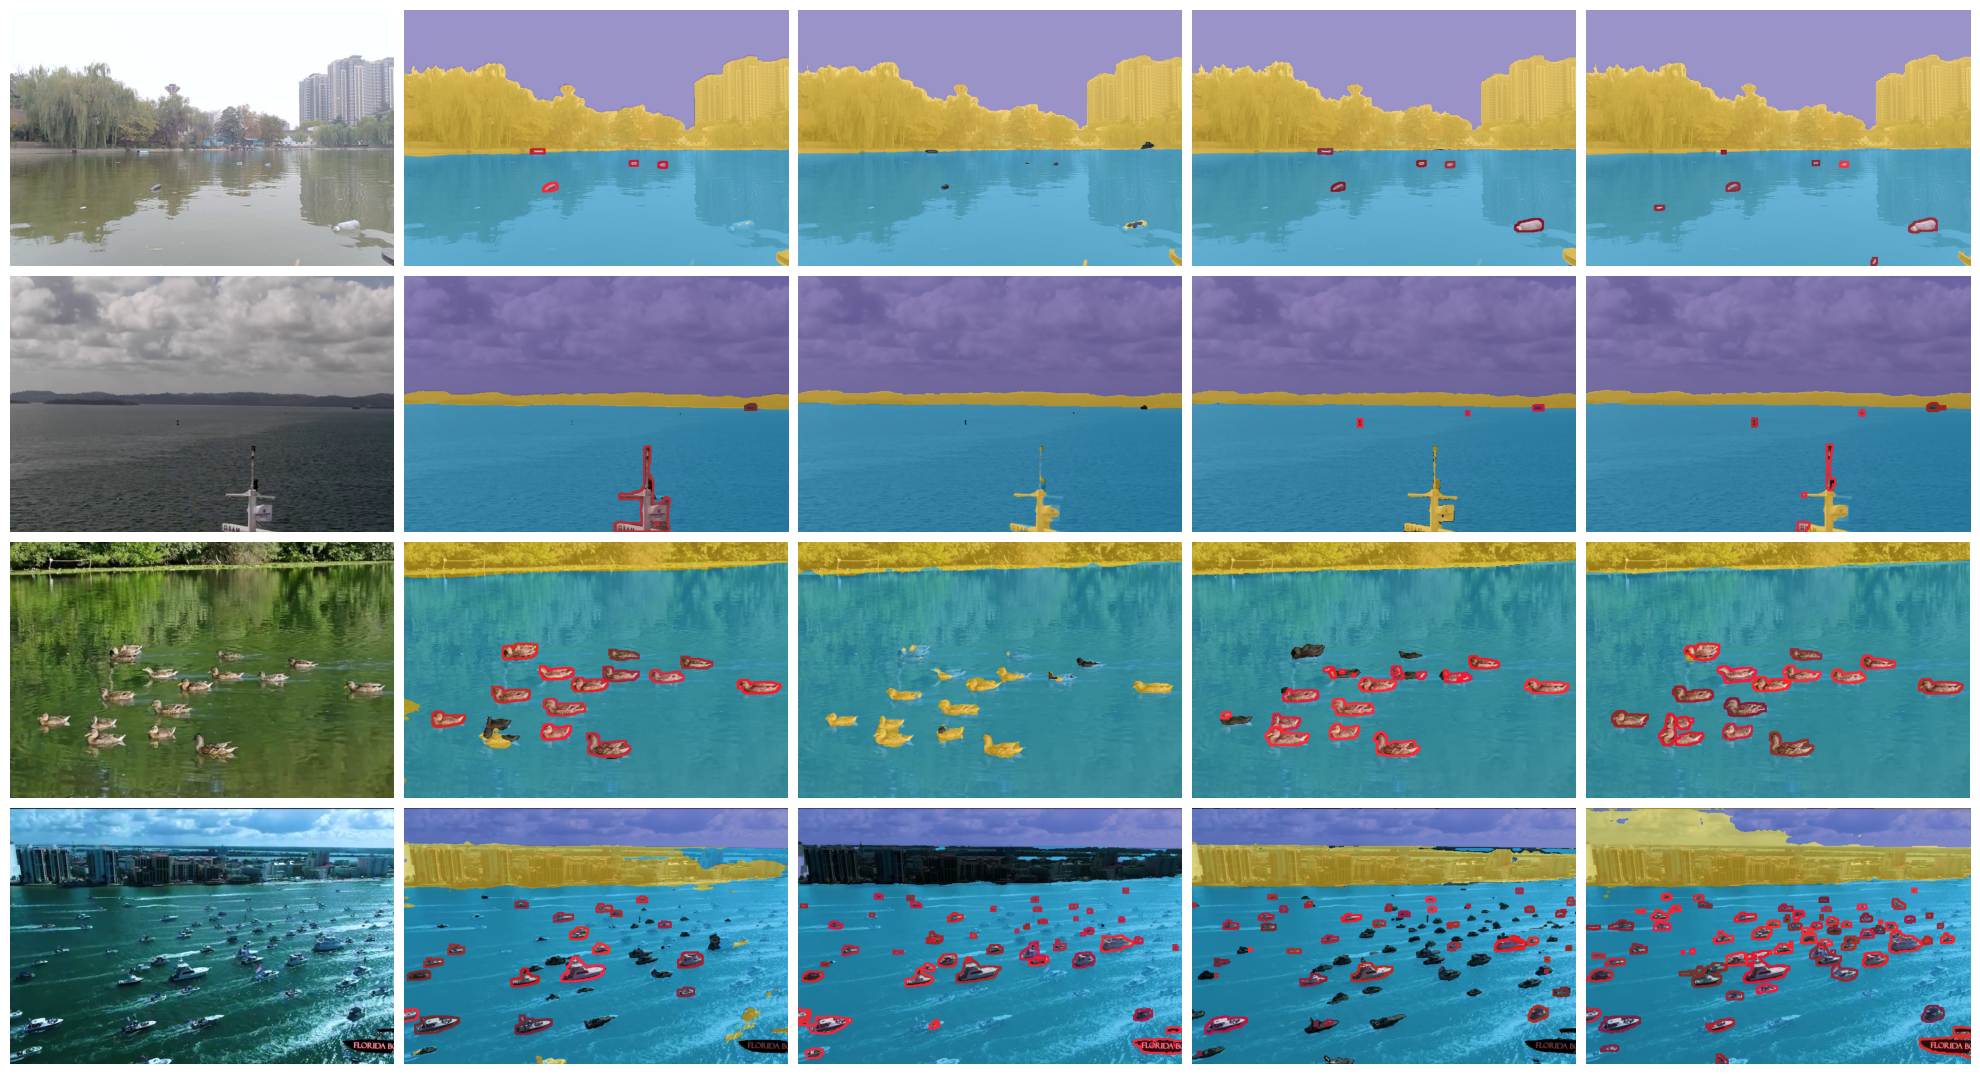

In [98]:
visualize_frames(['orca_flow_3_00140', 'yt089_05_00100', 'yt010_02_00045', 'yt081_02_00022'], show_original=True, transpose=True);
plt.savefig('figures/panoptic_qualitative.pdf', bbox_inches='tight')

In [ ]:
stored2 =[
    'inhouse_MatejK_Koper25.9.2021_IMG_8418_00015',
    'yt081_02_00022',
    'yt010_02_00045', # race pogube
    'orca_flow_3_00140', # flase pogube
    'yt089_05_00100', # m2f raztura
]